# **EXPLORATION OF DATA FOR ETL**

* Libraries to import

In [1]:
# for files
import os
import zipfile
import requests
from io import BytesIO
import time

# for data
import re
import numpy as np
import pandas as pd
import geopandas as gpd

# for viz
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

There are a couple of issues making it difficult to work with this dataset:
   >* At the time of this project, my setup has memory issues and the larger the df is in memory, the more probable it is that the kernel unexpectably shuts down
   >* I have a terrible internet connection

Therefore, the first text_file from data.zip was loaded in memory to be able to work in parallel with the hole df in data.zip

___________________

### **1**
### GLOBAL VARIABLES 

* **1.1** DATA SOURCES

In [2]:
# Data sources found in the test repository:

#### NYC TAXI Data (Jan, Apr, July 2015)
NYC_TAXI_ZIP = 'https://storage.googleapis.com/hiring-test/data.zip'
#### Data dictionary of NYC taxi data
NYC_TAXI_DICT = 'https://storage.googleapis.com/hiring-test/data_dictionary_trip_records_yellow.pdf'
#### ACS demopgraphic and socio-economic data by census block group (self-explanatory variables)
NYC_ACS = 'https://storage.googleapis.com/hiring-test/nyc_acs_demographics.csv'
#### NYC census block group geometries
NYC_BLOCK_GEOM = 'https://storage.googleapis.com/hiring-test/nyc_cbg_geoms.geojson'

* **1.2** DATA DICTIONARIES

Explanation of some cols as indicated in NYC_TAXI_DICT

In [3]:
VENDORID_DICT = {
    1: 'Creative_Mobile_Technologies',
    2: 'VeriFone_INC',
}

RATECODEID_DICT = {
    1: 'Standard_Rate',
    2: 'JFK',
    3: 'Newark_Westchester',
    4: 'Nassau',
    5: 'Negotiated',
    6: 'Group_Ride',
    99:'UNKNOWN',
}

PAYMENTTYPE_DICT = {
    1: 'Credit_Card',
    2: 'Cash',
    3: 'No_Charge',
    4: 'Dispute',
    5: 'Unknown',
    6: 'Voided_Trip'    
}

__________

### **2**
### FUNCTIONS

* **2.1** DATA LOADING

In [10]:
# --------------------------------------------------------------------------------------------------------------------------- OPENING FILES
def request_info_from_ZIP(zipfile_dir):
    """
    input
    output
    """
    print(f"---------------------- Getting ZIP file")
    tic = time.perf_counter()
    
    response = requests.get(zipfile_dir, stream = True)
    f = BytesIO()
    f.write(response.content)
    
    toc = time.perf_counter()
    mins = (toc-tic)//60; secs = np.around((toc-tic)%60, 3)
    
    print(f"---------------------- Done in {mins}'{secs}''")
    return f

def getting_df_fromZip(zipfile_info, minLen_toDisgard, first_row = 5, num_rows = 35):
    """
    input
    output
    """
    filenames, frame_to_concat = [], []   
    # Open and concat df
    print(f"---------------------- Opening ZIP file and construction of DF \n"); tic = time.perf_counter()
    
    with zipfile.ZipFile(zipfile_info) as zip_:
        for filename in zip_.namelist():
            if len(filename) > minLen_toDisgard:
                # there is a folder data/ with nothing inside
                # this is to only pick valid textfiles
                # based on their lenght 
                with zip_.open(filename) as file_:
                    if len(filenames) == 0:
                        # for first file in data.zip
                        first_frame = pd.read_csv(file_, sep = ',')
                        
                        # FOR THE SAKE OF THE EXERCISE
                        # ONLY 1 EVERY 20 ROWS ARE READ (20K FROM 500K)
                        frame_to_use = first_frame.loc[first_row::num_rows]
                        #    
                        
                        column_names = first_frame.columns.tolist()
                        filenames.append(filename); frame_to_concat.append(frame_to_use)
                        
                        memory_usage = frame_to_use.memory_usage(index = True, deep = False).sum()/(1000*1024)
                        print(f"{filename} \tDone \t Memory Usage: {np.around(memory_usage, 2)} Mb \t Shape {frame_to_use.shape}")

                    else:
                        new_frame = pd.read_csv(file_, sep = ',', names = column_names)
                        
                        # FOR THE SAKE OF THE EXERCISE
                        # ONLY 1 EVERY 20 ROWS ARE READ (20K FROM 500K)
                        # Nth purge because data seamed ordered by pickup data, therefore there is some garanty of unbiased data
                        # TO AVOID EXCESS USE OF MEMORY 
                        frame_to_use = new_frame.loc[first_row::num_rows]
                        # BUT
                        # A REAL CASE USE WOULD USE ALL DATA AVAILABLE                       
                        
                        
                        filenames.append(filename); frame_to_concat.append(frame_to_use)
                        memory_usage += frame_to_use.memory_usage(index = True, deep = False).sum()/(1000*1024)
                        
                        print(f"{filename} \tDone \t Memory Usage: {np.around(memory_usage, 2)} Mb \t Shape {frame_to_use.shape}")
                         
    toc = time.perf_counter(); mins = (toc-tic)//60; secs = np.around((toc-tic)%60, 3)     
    print(f"\n ---------------------- Done Running all in {mins}'{secs}'' \t Total frames {len(frame_to_concat)} return as {type(frame_to_concat)}")
    
    # returns list of list of DFs
    return frame_to_concat

# --------------------------------------------------------------------------------------------------------------------------- OPENING FILES: Aux for notebook
def getting_FirstdDF_fromZip(zipfile_info, minLen_toDisgard):
    """
    input
    output
    """
    filenames = []
    # Open and concat df
    print(f"---------------------- Opening ZIP file and construction of DF \n"); tic = time.perf_counter()
    
    with zipfile.ZipFile(zipfile_info) as zip_:

        for filename in zip_.namelist():
            if len(filename) > minLen_toDisgard:
                # there is a folder data/ with nothing inside
                # this is to only pick valid textfiles
                # based on their lenght 
                with zip_.open(filename) as file_:
                    if len(filenames) == 0:
                        # for first file in data.zip
                        first_frame = pd.read_csv(file_, sep = ',')
                        
                        filenames.append(filename)
                        memory_usage = first_frame.memory_usage(index = True, deep = False).sum()/(1000*1024)
                        print(f"{filename} \tDone \t Memory Usage: {np.around(memory_usage, 2)} Mb \t Shape {first_frame.shape}")
                        
                        toc = time.perf_counter(); mins = (toc-tic)//60; secs = np.around((toc-tic)%60, 3)     
                        print(f"\n ---------------------- Done Running all in {mins}'{secs}'' \t Total frames {len(first_frame)} return as {type(first_frame)} \n")
                        # returns list of list of DFs
                        return first_frame

* **2.2** DATA TRANSFORMATION

In [5]:
# --------------------------------------------------------------------------------------------------------------------------- OBJECT TO DATETIME
def str_to_datetime(date_string):
    """
    input: '2015-07-02 14:04:06'  <str>
    output: '2015-07-02T14:04:06' <datetime>
    """
    try:
        date_stt = date_string.split(" ")[0]
        time_str = date_string.split(" ")[1]
        result = np.datetime64(date_stt) + np.timedelta64(time_str.split(":")[0], 'h') + np.timedelta64(time_str.split(":")[1], 'm') + np.timedelta64(time_str.split(":")[2], 's')
        return result

    
    except:
        print(f"!! \t String value does not match:  {date_string}")
        return np.nan
    
def datetime_transformations(datetime_cols, df, drop_cols):
    """
    input:   
    output:   
    """
    str_to_datetime_vect = np.vectorize(str_to_datetime)
    print(f"---------------------- Transform OBJECT to DATETIME")
    
    for Dtime_col in datetime_cols:
        
        tic = time.perf_counter()
        new_col_name = Dtime_col.split("_")[1] + '_' + Dtime_col.split("_")[2]
        
        df[new_col_name] = str_to_datetime_vect(df[Dtime_col])
        if drop_cols: df.drop(columns = [Dtime_col], axis = 1, inplace = True)
        
        toc = time.perf_counter(); 
        mins = (toc-tic)//60; secs = np.around((toc-tic)%60, 3)
        
        print(f"{Dtime_col} transformed in {mins}'{secs}''")
        

# --------------------------------------------------------------------------------------------------------------------------- OBJECT TO GEOMETRY
def coord_to_geomObject(df, drop_bool = False):
    """
    input: df[lat], df[long] --> 40  3
    output: df[point]        --> Point(40,3)
    """
    print(f"\n---------------------- Transform OBJECTS to GEOMETRIES")
    tic = time.perf_counter()
    
    # find pairs
    latitude = sorted([col for col in df.columns if re.findall(r'latitud', col)])
    longitud = sorted([col for col in df.columns if re.findall(r'longitude', col)])
    print(f"Latitude cols found:\t {latitude}"); print(f"Longitude cols found:\t {longitud}"); print()
    
    # error if
    assert len(latitude) == len(longitud)
    #there has to be the same lats as longs for constr points
    
    for lng, lat in zip(longitud, latitude):
            
            if lng.split('longitude') == lat.split('latitude'):
                new_col_name = [n.strip()+'geometry' for n in lng.split('longitude') if len(n) !=0][0]
            
            df[new_col_name] = gpd.points_from_xy(df[lng], df[lat])
            print(f"Adding new col:\t {new_col_name}\tDone")
            
    print(f"\nDropping cols {latitude + longitud}\t\t{str(drop_bool).upper()}")
    if drop_bool: df.drop(columns = latitude + longitud, axis = 1, inplace = True)
        
    toc = time.perf_counter()
    mins = (toc-tic)//60; secs = np.around((toc-tic)%60, 3)
    
    print(f" Objects transformed in {mins}'{secs}''")
    #no return
    

# --------------------------------------------------------------------------------------------------------------------------- PRICES TO POSITIVE NUMBS
def abs_var_col(df, cols):
    """
    some numerics cols for prices are negative (all row neg). This is a corrective def
    """
    print(f"\n---------------------- Transform NEG PRICES to POSITIVE PRICES")
    tic = time.perf_counter()
    
    for col in cols:
        try:
            df[col] = np.abs(df[col])
        except: pass
    
    toc = time.perf_counter()
    mins = (toc-tic)//60; secs = np.around((toc-tic)%60, 3)
    
    print(f" Objects transformed in {mins}'{secs}''") 
# --------------------------------------------------------------------------------------------------------------------------- GETTING RID OF CASH ERRORS

def total_amount_inconsistency(df, cols_to_sum, total_col):
    """
    drop all cols that are inconsistent in the total amount payed for the trip
    """
    print(f"\n---------------------- Dropping CASH ERRORS")
    tic = time.perf_counter()
    
    # create col for and drop if aux_col == False
    aux_col = 'amount_equality'
    
    df[aux_col] = df.apply(lambda x: np.around(np.sum(x[cols_to_sum]), 3) == x[total_col], axis = 1)
    df.drop(df[df[aux_col] == False].index, inplace = True)
    
    # del aux_col
    df.drop(columns = [aux_col], axis = 1, inplace = True)
    
    toc = time.perf_counter()
    mins = (toc-tic)//60; secs = np.around((toc-tic)%60, 3)
    
    print(f" Objects transformed in {mins}'{secs}''") 
    # no return


* **2.3** DATA VIZ (text lists and print formatting)

In [6]:
# --------------------------------------------------------------------------------------------------------------------------- FUNCTION FOR VIZ
def repr_col(gdf, col, dic = None):
    """
    little thing to shorten print code for columns exploration
    """
    gdf_ser = gdf[col].value_counts()
    for i, val in enumerate(sorted(gdf_ser.index)):
        
        # Name
        if dic != None: name = dic[val]
        else: name = str(val)
        
        # Tabulation 
        if len(name) < 7: tab = '\t'*5
        elif 7 <= len(name) < 15: tab = '\t'*4
        elif 15 <= len(name) < 22: tab = '\t'*3  
        elif 15 <= len(name) < 30: tab = '\t'*2
        else: tab = '\t'*1        
    
        print(f"{name} {tab} {str(gdf_ser[val]).zfill(6)} \t{str(np.around(gdf_ser[val] *100 / gdf.shape[0], 3)).zfill(6)} %")
        # no return
        

def construc_lstRanges(num_0 = 0, num_1 = 10):
    return [[num,num+1] for num in range(num_0,num_1)]


def counts_per_discRanges(col, ranges = construc_lstRanges(0,10)):

    counts = [0 for rang in ranges]
    
    for row in col:
        for i, rang in enumerate(ranges):
            if rang[0] <= row < rang[1]: counts[i] += 1
            else: pass
    return counts

* **2.4** DEF FOR TRANSFORMATION 

In [7]:
def data_etl(df_to_transform, drop_cols = True):
    """
    input
    output
    """   
    datetime_cols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']
    abs_cols = ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'improvement_surcharge', 'tolls_amount', 'total_amount']
    cat_cols = ['RatecodeID', 'payment_type']
    num_cols_to_sum = ['fare_amount', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'mta_tax', 'extra']
    total_payment_col = 'total_amount'
    cols_to_drop = ['VendorID', 'store_and_fwd_flag', 'total_amount']
    
    existing_cols = set(datetime_cols + abs_cols +cat_cols + num_cols_to_sum + [total_payment_col] + cols_to_drop)
    
    assert existing_cols not in df_to_transform.columns.tolist()
    
    # 1.1
    # FRPM OBJECT TO DATETIME

    datetime_transformations(datetime_cols = datetime_cols, 
                         df = df_to_transform, drop_cols = True)
    # 1.2
    # OBJECT TO GEOMETRY
    coord_to_geomObject(df_to_transform, drop_bool = True)
    
    # 2
    # NUMERIC COLS IN ABSOLUTES
    abs_var_col(df_to_transform, cols = abs_cols)
    
    # 3
    # CATEGORICAL COLUMNS
    df_to_transform[cat_cols[0]] = df_to_transform[cat_cols[0]].apply(lambda col: RATECODEID_DICT[col]) # change dicts
    df_to_transform[cat_cols[1]] = df_to_transform[cat_cols[1]].apply(lambda col: PAYMENTTYPE_DICT[col]) # change dicts
    
    #  4
    # Drops columns with inconsistency in amount
#     total_amount_inconsistency(df = df_to_transform,
#                                cols_to_sum = num_cols_to_sum,
#                                total_col = total_payment_col)
    
    if drop_cols: df_to_transform.drop(columns = cols_to_drop, axis = 1, inplace = True)
    else: pass
    
    return df_to_transform

_____________

### **3**
### OPENING FILES

* Get information from link source: *my setup needs around from 5m-15min to finish running*

In [9]:
info_from_zip = request_info_from_ZIP(zipfile_dir = NYC_TAXI_ZIP)

---------------------- Getting ZIP file
---------------------- Done in 3.0'46.156''


* Let's construct DFs to have a look into the data an clean it

In [8]:
df_for_eda = getting_FirstdDF_fromZip(zipfile_info = info_from_zip,  minLen_toDisgard = 7)

---------------------- Opening ZIP file and construction of DF 

data/yellow_tripdata_2015-07_00 	Done 	 Memory Usage: 74.22 Mb 	 Shape (499999, 19)

 ---------------------- Done Running all in 0.0'0.785'' 	 Total frames 499999 return as <class 'pandas.core.frame.DataFrame'> 



In [ ]:
frames = getting_df_fromZip(zipfile_info = info_from_zip,  
                            minLen_toDisgard = 7, 
                            first_row = 5,
                            num_rows = 35)

---------------------- Opening ZIP file and construction of DF 

data/yellow_tripdata_2015-07_00 	Done 	 Memory Usage: 2.12 Mb 	 Shape (14286, 19)


/home/lucia/miniconda3/envs/geoesp_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (0,3,4,5,6,7,9,10,11,12,13,14,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data/yellow_tripdata_2015-01_00 	Done 	 Memory Usage: 4.24 Mb 	 Shape (14286, 19)
data/yellow_tripdata_2015-01_01 	Done 	 Memory Usage: 6.36 Mb 	 Shape (14286, 19)
data/yellow_tripdata_2015-01_02 	Done 	 Memory Usage: 8.48 Mb 	 Shape (14286, 19)
data/yellow_tripdata_2015-01_03 	Done 	 Memory Usage: 10.6 Mb 	 Shape (14286, 19)
data/yellow_tripdata_2015-01_04 	Done 	 Memory Usage: 12.72 Mb 	 Shape (14286, 19)
data/yellow_tripdata_2015-01_05 	Done 	 Memory Usage: 14.84 Mb 	 Shape (14286, 19)
data/yellow_tripdata_2015-01_06 	Done 	 Memory Usage: 16.97 Mb 	 Shape (14286, 19)
data/yellow_tripdata_2015-01_07 	Done 	 Memory Usage: 19.09 Mb 	 Shape (14286, 19)
data/yellow_tripdata_2015-01_08 	Done 	 Memory Usage: 21.21 Mb 	 Shape (14286, 19)
data/yellow_tripdata_2015-01_09 	Done 	 Memory Usage: 23.33 Mb 	 Shape (14286, 19)
data/yellow_tripdata_2015-01_10 	Done 	 Memory Usage: 25.45 Mb 	 Shape (14286, 19)
data/yellow_tripdata_2015-01_11 	Done 	 Memory Usage: 27.57 Mb 	 Shape (14286, 19)
data/yel

In [14]:
display(frames[1].head(2));display(frames[1].shape)
display(frames[2].head(2));display(frames[2].shape)
display(frames[3].head(2));display(frames[3].shape)
display(frames[4].head(2));display(frames[4].shape)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
5,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176147460938,40.762428283691406,1,N,-74.004180908203125,40.742652893066406,2,15,0.5,0.5,0,0,0.3,16.3
40,2,2015-01-25 00:13:05,2015-01-25 00:29:11,1,1.73,-73.985939025878906,40.726764678955078,1,N,-74.006546020507813,40.737865447998047,2,11,0.5,0.5,0,0,0.3,12.3


(14286, 19)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
5,2,2015-01-09 09:55:48,2015-01-09 10:51:17,2,20.8,-73.790070,40.646881,2,N,-74.009346,40.702316,2,52.0,0.0,0.5,0.0,5.33,0.3,58.13
40,1,2015-01-15 00:14:03,2015-01-15 00:18:29,1,1.0,-73.995232,40.646057,1,N,-74.008568,40.648632,2,5.5,0.5,0.5,0.0,0.00,0.3,6.80


(14286, 19)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
5,2,2015-01-12 17:14:28,2015-01-12 17:25:50,1,1.81,-73.963036,40.776733,1,N,-73.982269,40.775246,1,10.0,1.0,0.5,2.20,0.0,0.3,14.00
40,1,2015-01-03 19:54:56,2015-01-03 19:57:56,1,0.40,-73.986450,40.749382,1,N,-73.992661,40.748035,1,4.0,0.0,0.5,0.95,0.0,0.0,5.75


(14286, 19)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
5,2,2015-01-31 10:42:32,2015-01-31 10:51:20,2,1.21,-73.959152,40.780834,1,N,-73.973389,40.789768,2,7.5,0.0,0.5,0.0,0.0,0.3,8.3
40,1,2015-01-19 19:14:34,2015-01-19 19:26:05,1,2.60,-73.978439,40.752541,1,N,-73.976662,40.780834,1,11.0,0.0,0.5,1.0,0.0,0.3,12.8


(14286, 19)

In [ ]:
for i, frame in enumerate(frames[::2]):
    print(f"\n\n{i} Frame ---------------------------------------------")
    tic = time.perf_counter()
    clean_frame = data_etl(df_to_transform = frame,
                                                drop_cols = True)
    
    toc = time.perf_counter()
    mins = (toc-tic)//60; secs = np.around((toc-tic)%60, 3)
    
    print(f" Frame cleaned in  transformed in {mins}'{secs}''")  



0 Frame ---------------------------------------------
---------------------- Transform OBJECT to DATETIME
tpep_pickup_datetime transformed in 0.0'0.158''
tpep_dropoff_datetime transformed in 0.0'0.14''

---------------------- Transform OBJECTS to GEOMETRIES
Latitude cols found:	 ['dropoff_latitude', 'pickup_latitude']
Longitude cols found:	 ['dropoff_longitude', 'pickup_longitude']

Adding new col:	 dropoff_geometry	Done
Adding new col:	 pickup_geometry	Done

Dropping cols ['dropoff_latitude', 'pickup_latitude', 'dropoff_longitude', 'pickup_longitude']		TRUE
 Objects transformed in 0.0'0.156''

---------------------- Transform NEG PRICES to POSITIVE PRICES
 Objects transformed in 0.0'0.001''
 Frame cleaned in  transformed in 0.0'0.46''


1 Frame ---------------------------------------------
---------------------- Transform OBJECT to DATETIME
tpep_pickup_datetime transformed in 0.0'0.149''
tpep_dropoff_datetime transformed in 0.0'0.143''

---------------------- Transform OBJECTS to GE

In [24]:
df_all = pd.concat(frames[::2])


>> *Note: 
Code to load all data provided*

In [ ]:
# frames = getting_df_fromZip(zipfile_info = info_from_zip,  minLen_toDisgard = 7)

* Once the frist chunck is in memory, lets check the DF:

In [9]:
df_for_eda.head(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2015-07-01 00:00:00,2015-07-01 00:15:26,1,3.5,-73.994156,40.751125,1,N,-73.976822,40.788567,2,14.0,0.5,0.5,0.0,0.0,0.3,15.3
1,1,2015-07-01 00:00:00,2015-07-01 00:22:22,1,3.9,-73.984657,40.768486,1,N,-74.000130,40.734898,2,17.0,0.5,0.5,0.0,0.0,0.3,18.3
2,1,2015-07-01 00:00:00,2015-07-01 00:07:42,1,2.3,-73.978889,40.762287,1,N,-74.004219,40.752533,2,9.0,0.5,0.5,0.0,0.0,0.3,10.3


In [25]:
df_all.head()

,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,pickup_datetime,dropoff_datetime,dropoff_geometry,pickup_geometry
0,1,3.5,Standard_Rate,Cash,14.0,0.5,0.5,0.00,0.0,0.3,2015-07-01,2015-07-01 00:15:26,POINT (-73.97682 40.78857),POINT (-73.99416 40.75113)
1,1,3.9,Standard_Rate,Cash,17.0,0.5,0.5,0.00,0.0,0.3,2015-07-01,2015-07-01 00:22:22,POINT (-74.00013 40.73490),POINT (-73.98466 40.76849)
2,1,2.3,Standard_Rate,Cash,9.0,0.5,0.5,0.00,0.0,0.3,2015-07-01,2015-07-01 00:07:42,POINT (-74.00422 40.75253),POINT (-73.97889 40.76229)
3,1,9.2,Standard_Rate,Credit_Card,33.0,0.5,0.5,8.55,0.0,0.3,2015-07-01,2015-07-01 00:39:37,POINT (-73.97151 40.63715),POINT (-73.99279 40.74276)
4,1,1.1,Standard_Rate,Credit_Card,6.0,0.5,0.5,2.00,0.0,0.3,2015-07-01,2015-07-01 00:05:34,POINT (-73.92033 40.75744),POINT (-73.91243 40.76981)


* Are there any **nulls** to handle?

In [10]:
display(df_for_eda.shape); display(df_for_eda.info())

(499999, 19)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499999 entries, 0 to 499998
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               499999 non-null  int64  
 1   tpep_pickup_datetime   499999 non-null  object 
 2   tpep_dropoff_datetime  499999 non-null  object 
 3   passenger_count        499999 non-null  int64  
 4   trip_distance          499999 non-null  float64
 5   pickup_longitude       499999 non-null  float64
 6   pickup_latitude        499999 non-null  float64
 7   RatecodeID             499999 non-null  int64  
 8   store_and_fwd_flag     499999 non-null  object 
 9   dropoff_longitude      499999 non-null  float64
 10  dropoff_latitude       499999 non-null  float64
 11  payment_type           499999 non-null  int64  
 12  fare_amount            499999 non-null  float64
 13  extra                  499999 non-null  float64
 14  mta_tax                499999 non-nu

None

**____________**

From this information, we can already see that there are data transformations to be done:
- pickup_longitude + pickup_latitude --> pickup_geometry
- dropoff_latitude + dropoff_latitude --> dropoff_geometry
- tpep_pickup_datetime --> datetime
- tpep_dropoff_datetime --> datetime

*Notes_____*

* DF could be splitted by pickup information and dropoff information.
* Outliers to handle better with block and ACS information EDA.

_______________

### **4**
### DATA TRANSFORMATIONS

* **4.1** FROM OBJECT TO DATETIME

Both columns have the same formatBoth columns have the same format

In [187]:
datetime_transformations(datetime_cols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime'], 
                         df = df_for_eda, drop_cols = True)

---------------------- Transform OBJECT to DATETIME
tpep_pickup_datetime transformed in 0.0'4.578''
tpep_dropoff_datetime transformed in 0.0'4.564''


*--------------*

B. OBJECT TO GEOMETRY

There are two geometries in this dataset:
>* Pickup  location
>* Dropoff location

In [188]:
coord_to_geomObject(df_for_eda, drop_bool = True)

Latitude cols found:	 ['dropoff_latitude', 'pickup_latitude']
Longitude cols found:	 ['dropoff_longitude', 'pickup_longitude']

Adding new col:	 dropoff_geometry	Done
Adding new col:	 pickup_geometry	Done

Dropping cols ['dropoff_latitude', 'pickup_latitude', 'dropoff_longitude', 'pickup_longitude']		TRUE


In [189]:
df_for_eda.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_datetime,dropoff_datetime,dropoff_geometry,pickup_geometry
0,1,1,3.5,1,N,2,14.0,0.5,0.5,0.00,0.0,0.3,15.30,2015-07-01,2015-07-01 00:15:26,POINT (-73.97682 40.78857),POINT (-73.99416 40.75113)
1,1,1,3.9,1,N,2,17.0,0.5,0.5,0.00,0.0,0.3,18.30,2015-07-01,2015-07-01 00:22:22,POINT (-74.00013 40.73490),POINT (-73.98466 40.76849)
2,1,1,2.3,1,N,2,9.0,0.5,0.5,0.00,0.0,0.3,10.30,2015-07-01,2015-07-01 00:07:42,POINT (-74.00422 40.75253),POINT (-73.97889 40.76229)
3,1,1,9.2,1,N,1,33.0,0.5,0.5,8.55,0.0,0.3,42.85,2015-07-01,2015-07-01 00:39:37,POINT (-73.97151 40.63715),POINT (-73.99279 40.74276)
4,1,1,1.1,1,N,1,6.0,0.5,0.5,2.00,0.0,0.3,9.30,2015-07-01,2015-07-01 00:05:34,POINT (-73.92033 40.75744),POINT (-73.91243 40.76981)


*---------------------*

### **B**. CATEGORICAL COLUMNS 

THere are some columns with codified information that it is uncertain whether it is useful for the prediction at hand

##### **B1**.VendorID: 
Column with code indicating the TPEP provider of the data.

In [190]:
repr_col(df_for_eda, col = 'VendorID', dic = VENDORID_DICT)

Creative_Mobile_Technologies 		 238890 	47.778 %
VeriFone_INC 				 261109 	52.222 %


**__________________**
##### **B2**. RatecodeID: 
Final code in effect at the end of the trip
* There is a code not specified in pdf key table provided, that is is understood that most probably it is the code asigned for unknown
* Also, looking at information in nyc.gov this column specifies the extra fares added to the final trip amount in relation to destination
* As shown in the nyc.gov:
> - Standard rate 
> - JFK (Airport)  +52.00 + 0.50
> - Newark (Airport) +17.50
> - Nassau (end nyc) +2.50
> - Negotiated fare
> - Group ride
* Although it variates in relation to traffic congestion and other surcharges*

This column may provide mininful insights about movility patterns and the use of taxi services in NYC

In [191]:
repr_col(df_for_eda, col = 'RatecodeID', dic = RATECODEID_DICT)

Standard_Rate 				 486809 	97.362 %
JFK 					 010413 	02.083 %
Newark_Westchester 			 001029 	00.206 %
Nassau 					 000177 	00.035 %
Negotiated 				 001555 	00.311 %
Group_Ride 				 000007 	00.001 %
UNKNOWN 				 000009 	00.002 %


**__________________**

##### **B3**. Store_and_fwd_flag: 
Indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server.

* It's a Y/N data type column
* Not relevant for the analysis at hand

In [192]:
repr_col(df_for_eda, col = 'store_and_fwd_flag')
# Most of the records where held offline

N 					 496351 	099.27 %
Y 					 003648 	000.73 %


*-------------------------------*

##### **B4**.Payment_type:
Code indicating how the passenger paid for the trip. *Might be related with tip_amount*

In [193]:
repr_col(df_for_eda, col = 'payment_type', dic = PAYMENTTYPE_DICT)

Credit_Card 				 319599 	063.92 %
Cash 					 178229 	35.646 %
No_Charge 				 001651 	000.33 %
Dispute 				 000520 	00.104 %


*_______*
#### **CONCLUSION**
* VendorID and Store_and_fwd_flag are dropped from gdf because it is clear that they do not provide useful information

In [324]:
df_for_eda['RatecodeID'] = df_for_eda['RatecodeID'].apply(lambda col: RATECODEID_DICT[col])
df_for_eda['payment_type'] = df_for_eda['payment_type'].apply(lambda col: PAYMENTTYPE_DICT[col])

In [194]:
df_for_eda.drop(columns = ['VendorID', 'store_and_fwd_flag'], axis = 1, inplace = True)

In [325]:
df_for_eda.head()

,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,pickup_datetime,dropoff_datetime,dropoff_geometry,pickup_geometry
0,1,3.5,Standard_Rate,Cash,14.0,0.5,0.5,0.00,0.0,0.3,2015-07-01,2015-07-01 00:15:26,POINT (-73.97682 40.78857),POINT (-73.99416 40.75113)
1,1,3.9,Standard_Rate,Cash,17.0,0.5,0.5,0.00,0.0,0.3,2015-07-01,2015-07-01 00:22:22,POINT (-74.00013 40.73490),POINT (-73.98466 40.76849)
2,1,2.3,Standard_Rate,Cash,9.0,0.5,0.5,0.00,0.0,0.3,2015-07-01,2015-07-01 00:07:42,POINT (-74.00422 40.75253),POINT (-73.97889 40.76229)
3,1,9.2,Standard_Rate,Credit_Card,33.0,0.5,0.5,8.55,0.0,0.3,2015-07-01,2015-07-01 00:39:37,POINT (-73.97151 40.63715),POINT (-73.99279 40.74276)
4,1,1.1,Standard_Rate,Credit_Card,6.0,0.5,0.5,2.00,0.0,0.3,2015-07-01,2015-07-01 00:05:34,POINT (-73.92033 40.75744),POINT (-73.91243 40.76981)


* RatecodeID and payment_type should be decoded to avoid mistakes

### **C**. NUMERIC COLUMNS

There are two types of information provided in this dataset:
* 1_ Cost of trip broken down by its fares, taxes, tip etc
* 2_ Trip information

*__________*
#### **C1**. TRIP COST:
(a) ¿? Do all the cost related columns have the same distribution

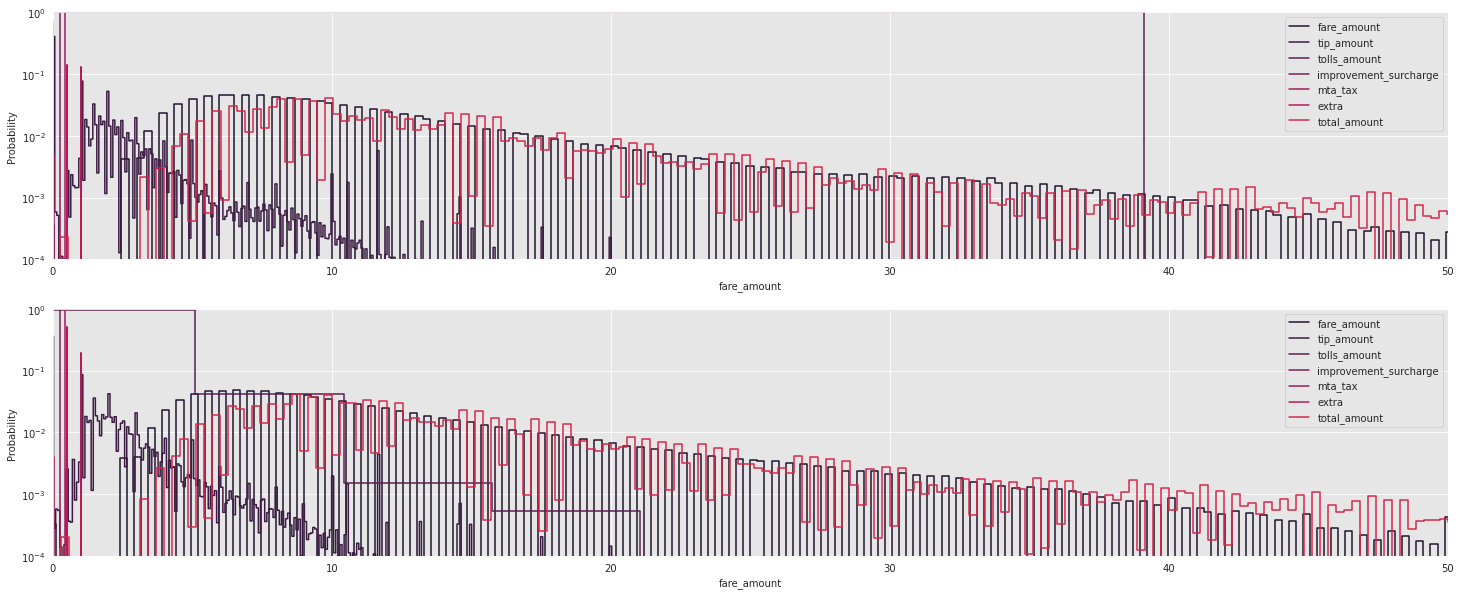

In [110]:
trip_cost_cols = ['fare_amount', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'mta_tax', 'extra', 'total_amount']

n = 250000
div = np.ceil(df_for_eda.shape[0]/n)

fix, ax = plt.subplots(ncols = 1, nrows = int(div), figsize = (25,10))

for j in range(0, int(div), 1):
    
    for i, col in enumerate(trip_cost_cols):

        sns.histplot(data = df_for_eda[n*j:(n*j)+n],
                     x = col,
                     element = 'step', stat = 'probability', common_norm = False,
                     color = rocket_palette[i], fill = False, label = col,
                     ax = ax[j])

    ax[j].set_yscale('log')
    
    ax[j].set_ylim([0.0001, 1])
    ax[j].set_xlim([0, 50])    
    ax[j].legend()
    
plt.show()
# plt.close()

# TABLES are closed to relieve weight

* total_amount and fare_amount have similar distributions as expected
* Outliers? fare_amount == 50-55
* For tax, tolls and other extra charges, the charges are below 1$
* Tip_amount has a very wide distribution with low probabilities for each value (low density)
* tolls_amount has diff distribution for each division but is always below 40 and with low density
* mta_tax is DISCRETE --> either -0.50 - 0.00 - 0.50
* extra is DISCRETE --> either 0 or 0.50
* improvement_surchage IS ALWAYS 0.5 or 0 --> could be dropped

THEREFORE, conclusions:
>- mta_tax, extra and improvement_surchage --> change by bool col or drop
>- fare_amount gives pretty much the same information as total_amount
>- tip_amount has different distribution and could be realted to ACS information
>- toll_amount alse has its own distribution

(b) ¿? fare_amount + extra + mta_tax + tip_amount + tolls_amount + improvement_surchage == total_mount 

In [196]:
df_for_eda.apply(lambda x: np.around(x['fare_amount'] + x['tip_amount'] + x['tolls_amount'] + x['improvement_surcharge'] + x['mta_tax'] + x['extra'], 3) == x['total_amount'], axis = 1).value_counts()

True     499955
False        44
dtype: int64

In [197]:
comparison_of_cost = df_for_eda.apply(lambda x: [np.around(x['fare_amount'] + x['tip_amount'] + x['tolls_amount'] + x['improvement_surcharge'] + x['mta_tax'] + x['extra'], 3), 
                                                 x['total_amount'], 
                                                 np.around(x['fare_amount'] + x['tip_amount'] + x['tolls_amount'] + x['improvement_surcharge'] + x['mta_tax'] + x['extra'], 3) == x['total_amount']], axis = 1)

for lst in comparison_of_cost:
    if lst[-1]: pass
    else: print(f"Sum price: {lst[0]}\t   Total amount: {lst[1]}\t\t{str(lst[2]).upper()}\t  Higher price: {['sum_price' if lst[0]>lst[1] else 'total_amount'][0]}")

Sum price: 19.8	   Total amount: 22.8		FALSE	  Higher price: total_amount
Sum price: 9.3	   Total amount: 11.06		FALSE	  Higher price: total_amount
Sum price: 22.8	   Total amount: 32.8		FALSE	  Higher price: total_amount
Sum price: 8.3	   Total amount: 9.86		FALSE	  Higher price: total_amount
Sum price: 25.3	   Total amount: 30.26		FALSE	  Higher price: total_amount
Sum price: 8.8	   Total amount: 11.29		FALSE	  Higher price: total_amount
Sum price: 7.3	   Total amount: 8.66		FALSE	  Higher price: total_amount
Sum price: 6.8	   Total amount: 8.38		FALSE	  Higher price: total_amount
Sum price: 8.8	   Total amount: 10.5		FALSE	  Higher price: total_amount
Sum price: 7.8	   Total amount: 9.26		FALSE	  Higher price: total_amount
Sum price: 15.8	   Total amount: 18.86		FALSE	  Higher price: total_amount
Sum price: 20.8	   Total amount: 24.86		FALSE	  Higher price: total_amount
Sum price: 8.3	   Total amount: 9.86		FALSE	  Higher price: total_amount
Sum price: 0.3	   Total amount: 0.0		FALS

There are 44 rows with a difference in total_amount price and sum price. Also, the total_amount is higher for sum_price < 1.

Let's a have a closer look at them and look for an explanation

 Let's check values in columns:

In [198]:
df_for_eda['amount_equality'] = df_for_eda.apply(lambda x: np.around(x['fare_amount'] + x['tip_amount'] + x['tolls_amount'] + x['improvement_surcharge'] + x['mta_tax'] + x['extra'], 3) == x['total_amount'], axis = 1)

df_false = df_for_eda[df_for_eda['amount_equality'] == False]
df_false.head()

,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_datetime,dropoff_datetime,dropoff_geometry,pickup_geometry,amount_equality
1534,1,6.06,1,2,18.5,0.5,0.5,0.0,0.0,0.3,22.80,2015-07-01 00:07:07,2015-07-01 00:24:07,POINT (-73.91081 40.76954),POINT (-73.94101 40.71258),False
19707,5,1.85,1,2,8.0,0.5,0.5,0.0,0.0,0.3,11.06,2015-07-01 02:02:15,2015-07-01 02:16:45,POINT (-73.94404 40.82791),POINT (-73.96373 40.80810),False
24363,2,6.51,1,2,21.5,0.5,0.5,0.0,0.0,0.3,32.80,2015-07-01 02:35:07,2015-07-01 02:57:41,POINT (-73.88666 40.74729),POINT (-73.97214 40.76330),False
43943,1,1.36,1,2,7.5,0.0,0.5,0.0,0.0,0.3,9.86,2015-07-01 06:28:54,2015-07-01 06:38:51,POINT (-73.96952 40.78518),POINT (-73.94926 40.77703),False
54029,1,7.60,1,2,24.5,0.0,0.5,0.0,0.0,0.3,30.26,2015-07-01 07:28:52,2015-07-01 07:50:56,POINT (-73.97202 40.75953),POINT (-73.99051 40.68665),False


In [199]:
display(repr_col(df_false, col = 'RatecodeID', dic = RATECODEID_DICT)); print()
display(repr_col(df_false, col = 'payment_type', dic = PAYMENTTYPE_DICT)); print()

Standard_Rate 				 000042 	95.455 %
JFK 					 000001 	02.273 %
Negotiated 				 000001 	02.273 %


None


Cash 					 000044 	0100.0 %


None

It is clear that the error is linked with the payment method. With no more information, the reason for this difference could be for two reasons:
* 1_ If total_amount is manually registered, it is an human error, made to gross the revenue of that taxi and downplay <1$ rides
* 2_ If fare_amount is manually registered, it is also an human error to probably hide a part of the taxi revenue

Because there no more information is provided and in 500k less than 50 rows have this contradiction (0,009 ~ 0.01%) It is information that could be dropped of

In [200]:
df_for_eda.drop(df_for_eda[df_for_eda['amount_equality'] == False].index, inplace = True)
df_for_eda.shape

(499955, 16)

In [201]:
df_for_eda.drop(columns = ['amount_equality'], axis = 1, inplace = True)

In [202]:
df_for_eda.head()

,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_datetime,dropoff_datetime,dropoff_geometry,pickup_geometry
0,1,3.5,1,2,14.0,0.5,0.5,0.00,0.0,0.3,15.30,2015-07-01,2015-07-01 00:15:26,POINT (-73.97682 40.78857),POINT (-73.99416 40.75113)
1,1,3.9,1,2,17.0,0.5,0.5,0.00,0.0,0.3,18.30,2015-07-01,2015-07-01 00:22:22,POINT (-74.00013 40.73490),POINT (-73.98466 40.76849)
2,1,2.3,1,2,9.0,0.5,0.5,0.00,0.0,0.3,10.30,2015-07-01,2015-07-01 00:07:42,POINT (-74.00422 40.75253),POINT (-73.97889 40.76229)
3,1,9.2,1,1,33.0,0.5,0.5,8.55,0.0,0.3,42.85,2015-07-01,2015-07-01 00:39:37,POINT (-73.97151 40.63715),POINT (-73.99279 40.74276)
4,1,1.1,1,1,6.0,0.5,0.5,2.00,0.0,0.3,9.30,2015-07-01,2015-07-01 00:05:34,POINT (-73.92033 40.75744),POINT (-73.91243 40.76981)


Ok.

Now, let's simplify some data.

*__________*
#### **C1**.1. OBJECT TO BOOL


mta_tax and improvement_surchage could be stored as **boolean**, which would make data lighter.

Let's look why some columns are negative

In [203]:
display(repr_col(df_for_eda, col = 'mta_tax')); print()
display(repr_col(df_for_eda, col = 'improvement_surcharge'))

-0.5 					 000162 	00.032 %
0.0 					 002231 	00.446 %
0.5 					 497562 	99.521 %


None


-0.3 					 000164 	00.033 %
0.0 					 000063 	00.013 %
0.3 					 499728 	99.955 %


None

In [204]:
display(df_for_eda[(df_for_eda['mta_tax'] < 0) | (df_for_eda['improvement_surcharge'] < 0)].shape)
display(df_for_eda[(df_for_eda['mta_tax'] < 0) | (df_for_eda['improvement_surcharge'] < 0)].head())

(165, 15)

,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_datetime,dropoff_datetime,dropoff_geometry,pickup_geometry
368,1,0.00,5,4,-60.0,0.0,-0.5,0.0,0.0,-0.3,-60.8,2015-07-01 00:01:22,2015-07-01 00:01:25,POINT (0.00000 0.00000),POINT (0.00000 0.00000)
799,1,0.00,5,3,-70.0,0.0,-0.5,0.0,0.0,-0.3,-70.8,2015-07-01 00:04:08,2015-07-01 00:10:28,POINT (0.00000 0.00000),POINT (0.00000 0.00000)
958,6,0.18,1,3,-3.0,-0.5,-0.5,0.0,0.0,-0.3,-4.3,2015-07-01 00:04:47,2015-07-01 00:05:28,POINT (-73.96628 40.75639),POINT (-73.96766 40.75619)
1899,1,0.06,1,3,-3.0,-0.5,-0.5,0.0,0.0,-0.3,-4.3,2015-07-01 00:02:40,2015-07-01 00:04:20,POINT (-73.96194 40.76768),POINT (-73.95915 40.76789)
2434,1,0.97,1,4,-6.0,-0.5,-0.5,0.0,0.0,-0.3,-7.3,2015-07-01 00:09:10,2015-07-01 00:14:43,POINT (-73.97650 40.73356),POINT (-73.99027 40.74053)


,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_datetime,dropoff_datetime,dropoff_geometry,pickup_geometry
368,1,0.00,5,4,-60.0,0.0,-0.5,0.0,0.0,-0.3,-60.8,2015-07-01 00:01:22,2015-07-01 00:01:25,POINT (0.00000 0.00000),POINT (0.00000 0.00000)
799,1,0.00,5,3,-70.0,0.0,-0.5,0.0,0.0,-0.3,-70.8,2015-07-01 00:04:08,2015-07-01 00:10:28,POINT (0.00000 0.00000),POINT (0.00000 0.00000)
958,6,0.18,1,3,-3.0,-0.5,-0.5,0.0,0.0,-0.3,-4.3,2015-07-01 00:04:47,2015-07-01 00:05:28,POINT (-73.96628 40.75639),POINT (-73.96766 40.75619)
1899,1,0.06,1,3,-3.0,-0.5,-0.5,0.0,0.0,-0.3,-4.3,2015-07-01 00:02:40,2015-07-01 00:04:20,POINT (-73.96194 40.76768),POINT (-73.95915 40.76789)
2434,1,0.97,1,4,-6.0,-0.5,-0.5,0.0,0.0,-0.3,-7.3,2015-07-01 00:09:10,2015-07-01 00:14:43,POINT (-73.97650 40.73356),POINT (-73.99027 40.74053)


In [205]:
print(f"For filter, data distribution for improvement_surcharge")
display(repr_col(df_for_eda[(df_for_eda['mta_tax'] < 0) | (df_for_eda['improvement_surcharge'] < 0)], 
         col = 'improvement_surcharge'))
print()
print(f"For filter, data distribution for mta_tax")
display(repr_col(df_for_eda[(df_for_eda['mta_tax'] < 0) | (df_for_eda['improvement_surcharge'] < 0)], 
         col = 'mta_tax'))

For filter, data distribution for improvement_surcharge
-0.3 					 000164 	99.394 %
0.0 					 000001 	00.606 %


None


For filter, data distribution for mta_tax
-0.5 					 000162 	98.182 %
0.0 					 000003 	01.818 %


None

Are the rest of columns also negative or zero? Is it a data fault?

In [206]:
for col in ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'improvement_surcharge', 'total_amount']:

    print(f"For filter, data distribution for {col}:"); [print(value) for value in df_for_eda[(df_for_eda['mta_tax'] < 0) | (df_for_eda['improvement_surcharge'] < 0)][col].value_counts().index if value >0]; print()

For filter, data distribution for fare_amount:

For filter, data distribution for extra:

For filter, data distribution for mta_tax:

For filter, data distribution for tip_amount:

For filter, data distribution for improvement_surcharge:

For filter, data distribution for total_amount:



In [226]:
abs_var_col(df_for_eda, cols = ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'improvement_surcharge', 'tolls_amount', 'total_amount'])

In [213]:
display(df_for_eda[(df_for_eda['mta_tax'] == 0.5) | (df_for_eda['improvement_surcharge'] == 0.3)].shape)
display(df_for_eda[(df_for_eda['mta_tax'] < 0) | (df_for_eda['improvement_surcharge'] < 0)].head())
display(df_for_eda[(df_for_eda['mta_tax'] < 0) | (df_for_eda['improvement_surcharge'] < 0)].head())

(0, 15)

,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_datetime,dropoff_datetime,dropoff_geometry,pickup_geometry


,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_datetime,dropoff_datetime,dropoff_geometry,pickup_geometry


In [224]:
display(repr_col(df_for_eda, col = 'mta_tax')); print()
display(repr_col(df_for_eda, col = 'improvement_surcharge')); print()
display(repr_col(df_for_eda, col = 'extra'));print()

0.0 					 002231 	00.446 %
0.5 					 497724 	99.554 %


None


0.0 					 000063 	00.013 %
0.3 					 499892 	99.987 %


None


0.0 					 256098 	51.224 %
0.3 					 000001 	0000.0 %
0.5 					 162487 	0032.5 %
1.0 					 081367 	16.275 %
1.3 					 000001 	0000.0 %
1.5 					 000001 	0000.0 %


None

In [220]:
# Now columns could be transformed to boolean information, but instead of that
# In order not to be dependant on knowing how much the tax / surcharfe is
# they are left like that

# It is more interesting to drop total_amount because
# (fare + extra + mta + tip + improvement) == total
# it is duplicated information

In [221]:
df_for_eda.drop(columns = 'total_amount', axis = 1, inplace = True)

In [222]:
df_for_eda.head(3)

,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,pickup_datetime,dropoff_datetime,dropoff_geometry,pickup_geometry
0,1,3.5,1,2,14.0,0.5,0.5,0.0,0.0,0.3,2015-07-01,2015-07-01 00:15:26,POINT (-73.97682 40.78857),POINT (-73.99416 40.75113)
1,1,3.9,1,2,17.0,0.5,0.5,0.0,0.0,0.3,2015-07-01,2015-07-01 00:22:22,POINT (-74.00013 40.73490),POINT (-73.98466 40.76849)
2,1,2.3,1,2,9.0,0.5,0.5,0.0,0.0,0.3,2015-07-01,2015-07-01 00:07:42,POINT (-74.00422 40.75253),POINT (-73.97889 40.76229)


They only column from trip cost left to have a look into is tolls_amount:

In [286]:
fix, ax = plt.subplots(figsize = (30,7), ncols = 1, nrows = 2)
sns.histplot(df_for_eda, y = 'tolls_amount', binrange = [0.1,5.5], bins = 250, ax = ax[0], stat = 'probability')
sns.histplot(df_for_eda, y = 'tolls_amount', binrange = [0,6.5], bins = 20, ax = ax[1], stat = 'probability')

# plt.show()
plt.close()

The chart shows a clear prevalence of 0 and 6 over rest of values, have +80% probability to show than the rest of the data

In [291]:
column = 'tolls_amount'
print(f"For column: {column.upper()}\n")
lst_of_ranges = construc_lstRanges(0, 12)
counts = counts_per_discRanges(df_for_eda[column], ranges = lst_of_ranges)  

for rng, count in zip(lst_of_ranges, counts):
    print(f"{rng}: \t{count} \t\t{np.around(count*100/df_for_eda.shape[0], 2)} %")
print("\n")

For column: TOLLS_AMOUNT

[0, 1]: 	474302 		94.87 %
[1, 2]: 	5 		0.0 %
[2, 3]: 	253 		0.05 %
[3, 4]: 	3 		0.0 %
[4, 5]: 	12 		0.0 %
[5, 6]: 	23799 		4.76 %
[6, 7]: 	17 		0.0 %
[7, 8]: 	16 		0.0 %
[8, 9]: 	38 		0.01 %
[9, 10]: 	319 		0.06 %
[10, 11]: 	7 		0.0 %
[11, 12]: 	594 		0.12 %




*__________*
#### **C2**. TRIP INFORMATION:

There are two columns columns about other important information about taxi trips:
* C2.1_ Passenger count: as the name indicates, its data about how many people shared the taxi trip
* C2.2_ Trip distance: miles made by the taxi

#### **C2.1**.Passenger count:

In [320]:
fix, ax = plt.subplots(figsize = (30,10), ncols = 1, nrows = 4)
sns.histplot(df_for_eda, y = 'passenger_count', binrange = [0,8], bins = 8, stat = 'count', legend = True, ax = ax[0])
sns.histplot(df_for_eda, y = 'passenger_count', x = 'RatecodeID', binrange = [0,8], bins = 8, stat = 'count', legend = True, ax = ax[1])
sns.histplot(df_for_eda, y = 'passenger_count', x = 'payment_type', binrange = [0,8], bins = 8, stat = 'count', legend = True, ax = ax[2])
sns.histplot(df_for_eda, y = 'passenger_count', x = 'tip_amount', binrange = [0,8], bins = 8, stat = 'count', legend = True, ax = ax[3])
# plt.show()
plt.close()

Most of this month rides were made by solo passengers, at standard rate and paid either in cash or credit card.

In [319]:
fix, ax = plt.subplots(figsize = (30,15), ncols = 1, nrows = 5)
sns.histplot(df_for_eda, y = 'trip_distance', binrange = [0,8], bins = 8, stat = 'count', legend = True, ax = ax[0])
sns.histplot(df_for_eda, y = 'trip_distance', x = 'passenger_count', binrange = [0,8], bins = 8, stat = 'count', legend = True, ax = ax[1])
sns.histplot(df_for_eda, y = 'trip_distance', x = 'RatecodeID', binrange = [0,8], bins = 8, stat = 'count', legend = True, ax = ax[2])
sns.histplot(df_for_eda, y = 'trip_distance', x = 'payment_type', binrange = [0,8], bins = 8, stat = 'count', legend = True, ax = ax[3])
sns.histplot(df_for_eda, y = 'trip_distance', x = 'tip_amount', binrange = [0,8], bins = 8, stat = 'count', legend = True, ax = ax[4])
# plt.show()
plt.close()

Most rides were less than 3 miles, with one 1 passenger, paying either in cash or credit card. Tip amount is more variable

In [326]:
df_for_eda.dtypes

passenger_count                   int64
trip_distance                   float64
RatecodeID                       object
payment_type                     object
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
pickup_datetime          datetime64[ns]
dropoff_datetime         datetime64[ns]
dropoff_geometry               geometry
pickup_geometry                geometry
dtype: object

ETL DONE!